In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import cv2
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
class MultiObjectDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, labels_folder, transform=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.transform = transform
        self.image_files = os.listdir(images_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_folder, image_name)
        label_path = os.path.join(self.labels_folder, image_name.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        labels = []
        bboxes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                x_length = float(parts[3])
                y_height = float(parts[4])

                labels.append(class_id)
                bboxes.append([x_center, y_center, x_length, y_height])

        labels = labels
        bboxes = bboxes

        if self.transform:
            image = self.transform(image)

        max_objects = 8  # Adjust based on dataset
        labels = labels + [-1] * (max_objects - len(labels))  # Pad with -1 for empty slots
        bboxes = bboxes + [[0, 0, 0, 0]] * (max_objects - len(bboxes))  # Dummy boxes for empty slots

        return image, torch.tensor(labels, dtype=torch.long), torch.tensor(bboxes, dtype=torch.float32)


In [5]:
class MultiObjectDetector(nn.Module):
    def __init__(self, max_objects=8):
        super(MultiObjectDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (80*2) * (64*2), 128)
        self.class_fc = nn.Linear(128, max_objects * 2)  # Class probabilities
        self.bbox_fc = nn.Linear(128, max_objects * 4)   # Bounding box coordinates

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * (80*2) * (64*2))
        x = F.relu(self.fc1(x))

        class_output = self.class_fc(x).view(-1, 8, 2)  # max_objects=8
        bbox_output = self.bbox_fc(x).view(-1, 8, 4)    # max_objects=8

        return class_output, bbox_output

In [6]:
def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):

    criterion_class = torch.nn.CrossEntropyLoss(ignore_index=-1)
    criterion_bbox = torch.nn.SmoothL1Loss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels, bboxes in train_loader:
            optimizer.zero_grad()

            #Forward pass
            class_outputs, bbox_outputs = model(images)

            class_loss = criterion_class(class_outputs.view(-1, 2), labels.view(-1))  # 2 classes
            bbox_loss = criterion_bbox(bbox_outputs.view(-1, 4), bboxes.view(-1, 4))  # 4 coordinates

            total_loss = class_loss + bbox_loss

            # Backward pass
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        # Print loss
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    print('Training complete.')

In [7]:
def predict(model, image, transform=None, threshold=0.9):
    model.eval()
    with torch.no_grad():
        if transform:
            image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        else:
            image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()  # Convert to tensor, add batch dimension

        class_output, bbox_output = model(image_tensor)

        predicted_classes = torch.argmax(class_output, dim=2)  # Get class predictions
        class_scores = torch.max(class_output, dim=2).values  # Get class scores

        valid_indices = (class_scores > threshold).nonzero(as_tuple=True) # Filter based on threshold

        predicted_classes = predicted_classes[valid_indices[0], valid_indices[1]].numpy()
        predicted_bboxes = bbox_output[valid_indices[0], valid_indices[1]].numpy()

        return predicted_classes, predicted_bboxes


In [8]:
images_folder = '/content/drive/MyDrive/Colab Notebooks/APS360/project/frames'
labels_folder = '/content/drive/MyDrive/Colab Notebooks/APS360/project/labels'

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 640)),
    transforms.ToTensor(),
])

dataset = MultiObjectDataset(images_folder, labels_folder, transform=transform)

# Collate function for variable-length lists
def collate_fn(batch):
    images, labels, bboxes = zip(*batch) # Unzip batch into images, labels, bboxes

    images = torch.stack(images)  # Stack images along  batch dimension

    labels = torch.stack(labels) # Stack lables
    bboxes = torch.stack(bboxes) # Stack bboxes

    return images, labels, bboxes

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

In [9]:
images, labels, bboxes = next(iter(train_loader))
print(bboxes) # Should be (batch_size, 3, height, width)

tensor([[[0.1549, 0.5394, 0.0308, 0.1083],
         [0.6461, 0.5593, 0.0292, 0.1454],
         [0.6251, 0.5613, 0.0298, 0.1149],
         [0.7428, 0.5798, 0.0223, 0.0500],
         [0.9155, 0.5795, 0.0377, 0.1180],
         [0.9711, 0.5641, 0.0363, 0.1441],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])


In [11]:
model = MultiObjectDetector(max_objects=8)
num_epochs = 100

train_model(model, train_loader, num_epochs=num_epochs, learning_rate=0.001)

Epoch [1/100], Loss: 3.0562
Epoch [2/100], Loss: 0.6376
Epoch [3/100], Loss: 0.6581
Epoch [4/100], Loss: 0.4874
Epoch [5/100], Loss: 0.3850
Epoch [6/100], Loss: 0.3291
Epoch [7/100], Loss: 0.3050
Epoch [8/100], Loss: 0.2820
Epoch [9/100], Loss: 0.2632
Epoch [10/100], Loss: 0.2538
Epoch [11/100], Loss: 0.2800
Epoch [12/100], Loss: 0.2406
Epoch [13/100], Loss: 0.2058
Epoch [14/100], Loss: 0.1784
Epoch [15/100], Loss: 0.1419
Epoch [16/100], Loss: 0.1105
Epoch [17/100], Loss: 0.1151
Epoch [18/100], Loss: 0.0915
Epoch [19/100], Loss: 0.0842
Epoch [20/100], Loss: 0.0889
Epoch [21/100], Loss: 0.0695
Epoch [22/100], Loss: 0.0442
Epoch [23/100], Loss: 0.0366
Epoch [24/100], Loss: 0.0373
Epoch [25/100], Loss: 0.0334
Epoch [26/100], Loss: 0.0301
Epoch [27/100], Loss: 0.0264
Epoch [28/100], Loss: 0.0224
Epoch [29/100], Loss: 0.0217
Epoch [30/100], Loss: 0.0173
Epoch [31/100], Loss: 0.0172
Epoch [32/100], Loss: 0.0209
Epoch [33/100], Loss: 0.0171
Epoch [34/100], Loss: 0.0179
Epoch [35/100], Loss: 0

In [ ]:
class_outputs, bbox_outputs = model(images)
print(class_outputs)

tensor([[[ 4.0255, -3.2699],
         [ 0.8461, -0.9292],
         [-1.1891, -0.8101],
         [-0.2709,  0.5592],
         [-0.0257,  0.7095],
         [ 0.7242, -1.7373],
         [ 0.7558, -0.4076],
         [ 0.6328, -0.1731]]], grad_fn=<ViewBackward0>)


In [22]:
def visualize_first_image(train_loader):
    # Get first batch from DataLoader
    images, labels, bboxes = next(iter(train_loader))

    # Get first image, label, and bounding box
    first_image = images[0]
    first_labels = labels[0]
    first_bboxes = bboxes[0]

    # Convert image tensor back to NumPy array for visualization
    first_image = first_image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)

    # Plot image
    plt.imshow(first_image)
    plt.axis('off')  # Hide axes

    # Get image dimensions
    height, width, _ = first_image.shape

    # Draw bounding boxes and labels
    for i in range(len(first_labels)):
        if first_labels[i] != -1:  # Skip padding labels
            # Convert center and size from percentages to pixel values
            x_center = first_bboxes[i][0].item() * width
            y_center = first_bboxes[i][1].item() * height
            x_width = first_bboxes[i][2].item() * width
            y_height = first_bboxes[i][3].item() * height

            # Calculate bounding box coordinates
            x1 = x_center - (x_width / 2)
            y1 = y_center - (y_height / 2)
            x2 = x_center + (x_width / 2)
            y2 = y_center + (y_height / 2)

            # Draw bounding box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
            plt.text(x1, y1, f'Class: {first_labels[i].item()}', color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

    plt.title('First Image and Labels')
    plt.show()

    # Print actual labels below image
    print("Actual Labels (Class, Bounding Box):")
    for i in range(len(first_labels)):
        if first_labels[i] != -1:  # Skip padding labels
            bbox = first_bboxes[i].numpy()
            print(f'Class: {first_labels[i].item()}, Bounding Box (Center, Width, Height): {bbox}')


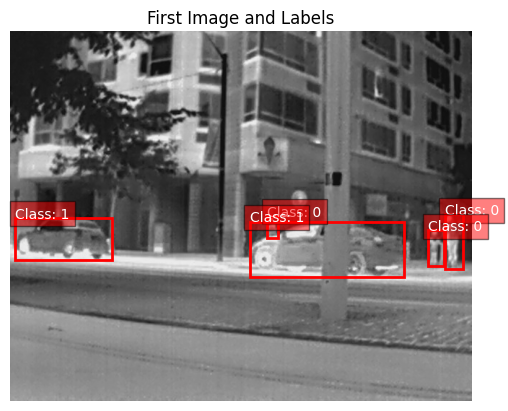

Actual Labels (Class, Bounding Box):
Class: 0, Bounding Box (Center, Width, Height): [0.567333 0.52744  0.023378 0.059109]
Class: 0, Bounding Box (Center, Width, Height): [0.959354 0.568285 0.038786 0.148768]
Class: 0, Bounding Box (Center, Width, Height): [0.9211   0.584889 0.033473 0.095637]
Class: 1, Bounding Box (Center, Width, Height): [0.115458 0.560902 0.209205 0.11576 ]
Class: 1, Bounding Box (Center, Width, Height): [0.684565 0.58831  0.333714 0.149613]


In [28]:
visualize_first_image(train_loader)

In [16]:
def visualize_first_prediction(model,image_num):

    # Load image for prediction
    test_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/APS360/project/frames/video_frame_' + image_num + '.jpg')

    # Transform image if necessary
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 640)),
        transforms.ToTensor(),
    ])

    # Call predict function
    predicted_classes, predicted_bboxes = predict(model, test_image, transform=transform)

    # Get first batch from DataLoader
    images, labels, bboxes = next(iter(train_loader))

    # Get first image, label, and bounding box
    first_image = test_image
    first_labels = predicted_classes
    first_bboxes = predicted_bboxes

    # Plot image
    plt.imshow(first_image)
    plt.axis('off')  # Hide axes

    # Get image dimensions
    height, width, _ = first_image.shape

    # Draw bounding boxes and labels
    for i in range(len(first_labels)):
        if first_labels[i] != -1:  # Skip padding labels
            # Convert center and size from percentages to pixel values
            x_center = first_bboxes[i][0].item() * width
            y_center = first_bboxes[i][1].item() * height
            x_width = first_bboxes[i][2].item() * width
            y_height = first_bboxes[i][3].item() * height

            # Calculate bounding box coordinates
            x1 = x_center - (x_width / 2)
            y1 = y_center - (y_height / 2)
            x2 = x_center + (x_width / 2)
            y2 = y_center + (y_height / 2)

            # Draw bounding box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
            plt.text(x1, y1, f'Class: {first_labels[i].item()}', color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

    plt.title('First Image and Labels')
    plt.show()

    # Print actual labels below image
    print("Actual Labels (Class, Bounding Box):")
    for i in range(len(first_labels)):
        if first_labels[i] != -1:  # Skip padding labels
            bbox = first_bboxes[i]
            print(f'Class: {first_labels[i].item()}, Bounding Box (Center, Width, Height): {bbox}')

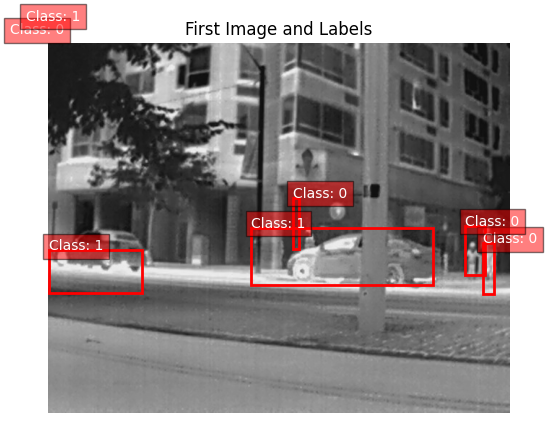

Actual Labels (Class, Bounding Box):
Class: 0, Bounding Box (Center, Width, Height): [0.5354739  0.48644984 0.01348232 0.14021292]
Class: 0, Bounding Box (Center, Width, Height): [0.9523891  0.6090498  0.02394099 0.13834757]
Class: 0, Bounding Box (Center, Width, Height): [0.9240259  0.55952674 0.04309262 0.13329795]
Class: 1, Bounding Box (Center, Width, Height): [0.10165821 0.6165219  0.20282364 0.11560279]
Class: 1, Bounding Box (Center, Width, Height): [0.6356196  0.5749288  0.39263728 0.15367837]
Class: 0, Bounding Box (Center, Width, Height): [-0.07295717 -0.01185922  0.02089823  0.02834404]
Class: 1, Bounding Box (Center, Width, Height): [-0.05398581 -0.04898268 -0.00985803  0.02602524]


In [18]:
image_num = '006363'
visualize_first_prediction(model,image_num)

In [ ]:
test_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/APS360/project/frames/video_frame_000001.jpg')  # Ensure your image is loaded correctly

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 640)),
    transforms.ToTensor(),
])

predicted_classes, predicted_bboxes = predict(model, test_image, transform=transform)

print(f'Predicted Classes: {predicted_classes}')
print(f'Predicted Bounding Boxes: {predicted_bboxes}')

Predicted Classes: [0 0 0]
Predicted Bounding Boxes: [[ 0.5254285   0.71028924  0.00815487  0.08804324]
 [ 0.59811646  0.6680114   0.04914045  0.0566491 ]
 [ 0.346196    0.06599816  0.05842048 -0.03672459]]
